# Transition analysis for ABL

This example uses [a microsecond trajectory of the kinase domain of human tyrosine kinase ABL1](https://figshare.com/articles/Microsecond_molecular_dynamics_simulation_of_kinase_domain_of_the_human_tyrosine_kinase_ABL1/4496795), kindly provided by John Chodera and Sonya Hanson. To run this notebook, download that data and unzip it in the directory from which you launch the notebook.

Since that data comes from Folding@Home, its frames are saved very infrequently. That means that the numeric values of things like fluxes might change with more resolution in the time step. However, this type of analysis is still an excellent way to check a proposed state definition.

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md
import openpathsampling as paths

from openpathsampling.engines.openmm.tools import ops_load_trajectory, topology_from_pdb

In [2]:
trajectory = ops_load_trajectory("4496795/run17-clone3.h5")
dfg_angle = paths.MDTrajFunctionCV(name="DFG",
                                   topology=trajectory.topology,
                                   f=md.compute_dihedrals,
                                   indices=[[2257,2255,2265,2270]])

This dihedral angle is meant to be a measure of the physiologically-significant DFG motif orientation in kinases. This particular angle was proposed in [Lin et al. PNAS **110** 1664 (2013)](https://doi.org/10.1073/pnas.1214330110).

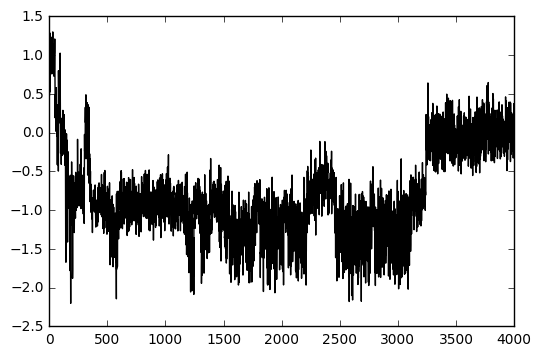

In [3]:
plt.plot(dfg_angle(trajectory), '-k')

Now we'll define a couple states. Note that the state definitions used here are not intended to represent the physiologically-significant states of the DFG motif. The specific bounds of these state definitions are chosen in order to create an example of how to use OpenPathSampling with this kind of data.

In [4]:
state_1 = paths.CVDefinedVolume(dfg_angle, 0.0, 1.0)
state_2 = paths.CVDefinedVolume(dfg_angle, -2.0, -0.75)

We want to analyze this trajectory for transitions between the two states, so we create a transition object to describe what we're studying.

In [5]:
transition = paths.TPSTransition(state_1, state_2)

Now we do that actual analysis:

In [6]:
analyzer = paths.TrajectoryTransitionAnalysis(transition)
analyzer.analyze(trajectory)

Once the analysis has been run for this trajectory, we can look at some of the results (which are stored in the analysis object).

The code here is just some standard matplotlib tricks to make the kind of plot we'd like. We want to show the trajectory, plotted according to some collective variable. 

In [7]:
def plot_segments(segments, trajectory, cv, *args, **kwargs):
    """Plot segments of a trajectory according to a CV.
    
    Additional *args and **kwargs are passed directly to plt.plot (to set style)
    
    Parameters
    ----------
    segments : list of paths.Trajectory
        the subtrajectories of `trajectory` to plot
    trajectory : paths.Trajectory
        the full trajectory
    cv : paths.CollectiveVariable
        a collective variable to put on the y-axis
    """
    indices = trajectory.subtrajectory_indices(segments)
    for (x_vals, seg) in zip(indices, segments):
        if x_vals != []:
            plt.plot(x_vals, cv(seg), *args, **kwargs)

## Continuous frames in the state

This is one of the easier parts of the analysis to understand. This just isolates all the segments of the total trajectory that are in each state. This is a quick way to check which frames are in each state, as well as checking how long your simulation stays in the state. Typically, you want to define your state such that the trajectory completely loses memory before it leaves the state.

In [8]:
# extract the data
state_1_segments = analyzer.continuous_segments[state_1]
state_2_segments = analyzer.continuous_segments[state_2]

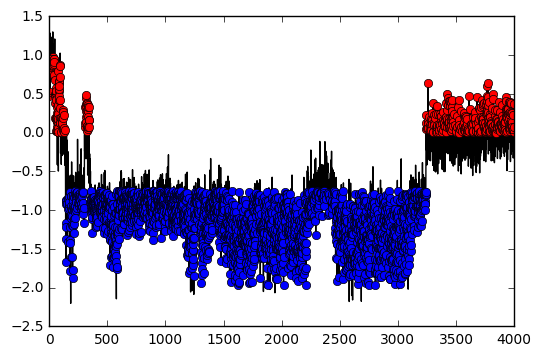

In [9]:
# and plot it
plt.plot(dfg_angle(trajectory), 'k')
plot_segments(state_1_segments, trajectory, dfg_angle, 'ro')
plot_segments(state_2_segments, trajectory, dfg_angle, 'bo')

That shows which frames are in each state. The more interesting information is in how long they stay in each state. We can look at the mean, or plot the whole distribution.

In [10]:
print("Number of continuous segments:",)
print(len(state_1_segments), len(state_2_segments))
print("Average length (frames):", np.mean(state_1_segments.n_frames), np.mean(state_2_segments.n_frames))

Number of continuous segments: 199 291
Average length (frames): 2.08040201005 8.83505154639


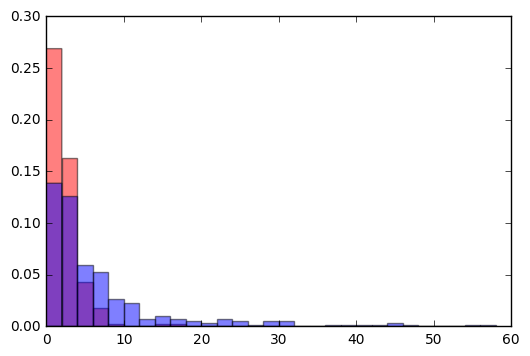

In [11]:
bin_spacing = np.arange(0, 60, 2)
plt.hist(state_1_segments.n_frames, bins=bin_spacing, density=True, alpha=0.5, color='r');
plt.hist(state_2_segments.n_frames, bins=bin_spacing, density=True, alpha=0.5, color='b');

## Lifetimes

The lifetime of a state is the (average) time from when it first enters the state (from another state) until it enters another state. The rate is the reciprocal of this lifetime. The analysis here finds all the segments that contribute to that lifetime. Here we don't bother to estimate the rate (since we have no more than 2 events per state), but we can calculate how many frames there are in each.

When we refer to the "time scale" of an event, we are usually refering to its lifetime.

In [12]:
lifetimes_1 = analyzer.lifetime_segments[state_1]
lifetimes_2 = analyzer.lifetime_segments[state_2]

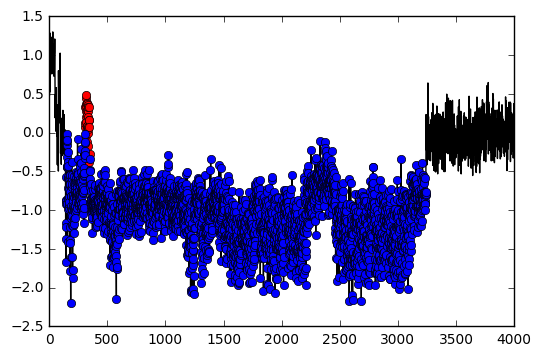

In [13]:
plt.plot(dfg_angle(trajectory), 'k')
plot_segments(lifetimes_1, trajectory, dfg_angle, 'ro')
plot_segments(lifetimes_2, trajectory, dfg_angle, 'bo')

In [14]:
print(lifetimes_1.n_frames)

[40]


In [15]:
print(lifetimes_2.n_frames)

[ 169 2891]


## Transition duration

One of the main ideas of path sampling is that, instead of running for the entire lifetime of a state in order to see a transition, we focus on what happens while the trajectory is in the no-man's land during the transition from one state to the other. Since this transition duration is usually orders of magnitude shorter than the lifetime, we can sample many transition events for much less computational cost. This effective increases the timescale accessible to simulation.

One of the important quantities for path sampling is therefore the transition duration. Ideally, the number of frames in the average transition is at least 50 or so. An average transition duration of 1000 or more might suggest that saving frames less frequently would be good way to save disk space.

This data comes from Folding@Home, and the frames are saved infrequently. Still, a committor analysis can be used on one of the transition frames in order to generate an initial path for path sampling.

In [16]:
transitions_1_to_2 = analyzer.transition_segments[(state_1, state_2)]
transitions_2_to_1 = analyzer.transition_segments[(state_2, state_1)]

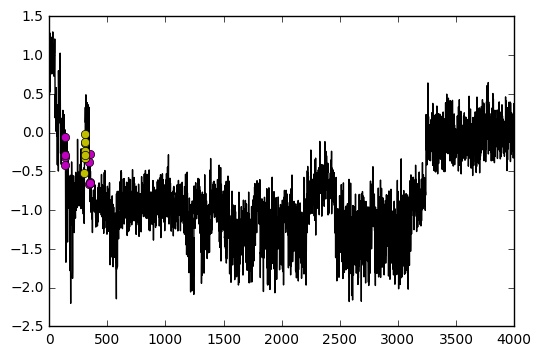

In [17]:
plt.plot(dfg_angle(trajectory), 'k')
plot_segments(transitions_1_to_2, trajectory, dfg_angle, 'mo')
plot_segments(transitions_2_to_1, trajectory, dfg_angle, 'yo')

In [18]:
print("Transition duration:", transitions_1_to_2.n_frames, transitions_2_to_1.n_frames)

Transition duration: [4 5] [7 0]


Note that the second transition from 2 to 1 doesn't have *any* frames in the no-man's land!

## Fluxes

Another quantity of interest in path sampling (especially TIS) is the flux out of a state and through an interface. This is defined by calculating the lifetime in the state and the lifetime outside the interface. The reciprocal of the sum of these is the flux. For more, see [van Erp, PRL **98** 268301 (2007)](https://doi.org/10.1103/PhysRevLett.98.268301).

If no interface is specified, the interface is treated as identical to the state. Another example will show how to use an interface explicitly.

In [19]:
# must set dt to calculate flux; here it in units of "frames"
analyzer.dt = 1.0

print(analyzer.flux(trajectory, state_2))

0.095279779905


If we want to see the details of the frames inside the interface and outside the interface, the `analyze_flux` method returns a dictionary with keys `'in'` and `'out'`, connecting respectively to the inside and outside segements.

In [20]:
flux_dict = analyzer.analyze_flux(trajectory, state_2)
flux_in_2 = flux_dict['in']
flux_out_2 = flux_dict['out']

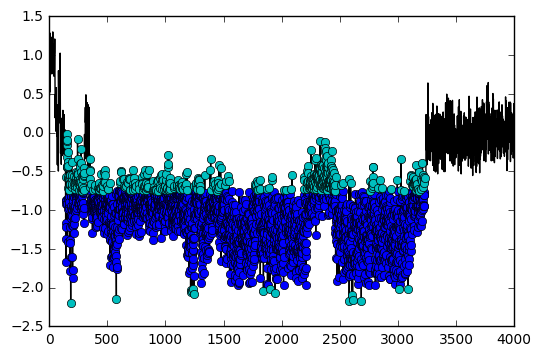

In [21]:
plt.plot(dfg_angle(trajectory), 'k')
plot_segments(flux_in_2, trajectory, dfg_angle, 'bo')
plot_segments(flux_out_2, trajectory, dfg_angle, 'co')

Note that the flux includes contributions in both positive and negative directions -- any time the trajectory leaves the state (and therefore the interface), it contributes.